In [ ]:
import kagglehub

path = kagglehub.dataset_download("cdeotte/jpeg-isic2019-512x512")

print("Path to dataset files:", path)


100%|██████████| 1.38G/1.38G [00:09<00:00, 152MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/cdeotte/jpeg-isic2019-512x512/versions/4


In [ ]:
import os

# List the dataset directory
print("Dataset files:", os.listdir(path))


Dataset files: ['train.csv', 'train']


In [ ]:
import pandas as pd

# Define the path (modify if needed)
df_path = os.path.join(path, "train.csv")

# Load CSV
df = pd.read_csv(df_path)

# Display the first few rows
print(df.head())


     image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_0000000          -1  female        55.0                anterior torso   
1  ISIC_0000001          -1  female        30.0                anterior torso   
2  ISIC_0000002          -1  female        60.0               upper extremity   
3  ISIC_0000003          -1    male        30.0               upper extremity   
4  ISIC_0000004          -1    male        80.0               posterior torso   

  diagnosis benign_malignant  target  tfrecord  width  height  
0        NV           benign       0         4   1022     767  
1        NV           benign       0        18   1022     767  
2       MEL        malignant       1         0   1022     767  
3        NV           benign       0        24   1022     767  
4       MEL        malignant       1        14   1022     767  


In [ ]:
image_folder = os.path.join(path, "train")

# List first 10 images
print(os.listdir(image_folder)[:10])


['ISIC_0067913.jpg', 'ISIC_0063457.jpg', 'ISIC_0055832.jpg', 'ISIC_0062442.jpg', 'ISIC_0066256.jpg', 'ISIC_0014699_downsampled.jpg', 'ISIC_0061738.jpg', 'ISIC_0061208.jpg', 'ISIC_0056102.jpg', 'ISIC_0071557.jpg']


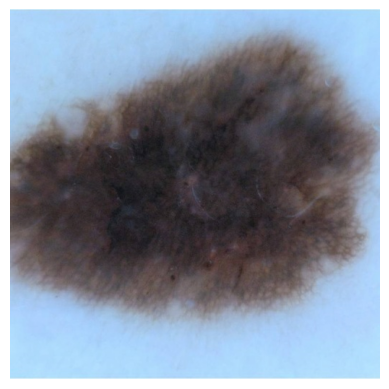

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Select an image
sample_image = os.path.join(image_folder, df.iloc[0]['image_name'] + ".jpg")  # Modify column name if needed

# Load and display image
image = tf.io.read_file(sample_image)
image = tf.image.decode_jpeg(image, channels=3)

plt.imshow(image.numpy())
plt.axis("off")
plt.show()


In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.4 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

# -------------------------------------------------------------------
# Define the NAS hypermodel for skin cancer classification
# -------------------------------------------------------------------
class SkinCancerHyperModel(kt.HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        inputs = keras.Input(shape=self.input_shape)
        x = inputs

        # Tune number of conv blocks (2 to 5)
        for i in range(hp.Int('num_blocks', 2, 3, default=3)):
            filters = hp.Choice(f'filters_{i}', [16, 32], default=32)
            x = layers.Conv2D(filters,
                              kernel_size=hp.Choice(f'kernel_size_{i}', [3, 5], default=3),
                              activation='relu',
                              padding='same')(x)
            x = layers.BatchNormalization()(x)
            if hp.Boolean(f'dropout_after_block_{i}', default=True):
                x = layers.Dropout(hp.Float(f'dropout_rate_{i}', 0.1, 0.5, step=0.1, default=0.3))(x)
            x = layers.MaxPooling2D()(x)

        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(hp.Int('dense_units', 32, 64, step=32, default=64), activation='relu')(x)
        x = layers.Dropout(hp.Float('dense_dropout', 0.1, 0.5, step=0.1, default=0.3))(x)
        outputs = layers.Dense(self.num_classes, activation='softmax')(x)

        model = keras.Model(inputs, outputs)
        model.compile(
            optimizer=keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log', default=1e-3)),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

In [ ]:
# -------------------------------------------------------------------
# Instantiate the hypermodel and tuner
# -------------------------------------------------------------------
input_shape = (224, 224, 3)
num_classes = 2  # benign vs malignant
hypermodel = SkinCancerHyperModel(input_shape, num_classes)

tuner = kt.Hyperband(
    hypermodel,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='nas_results',
    project_name='skin_cancer_nas'
)
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
import tensorflow as tf
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Create full paths to each image
df["image_path"] = df["image_name"].apply(lambda x: os.path.join(image_folder, f"{x}.jpg"))

# Encode labels
label_encoder = LabelEncoder()
df["label_encoded"] = label_encoder.fit_transform(df["benign_malignant"])

# Train-validation split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label_encoded"])

# TensorFlow dataset loader
def preprocess_image(filename, label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # Resize as needed
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def load_dataset(image_paths, labels, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Build datasets
train_dataset = load_dataset(train_df["image_path"].values, train_df["label_encoded"].values)
val_dataset = load_dataset(val_df["image_path"].values, val_df["label_encoded"].values)


In [ ]:
print(f"Training images:   {len(train_df)}")
print(f"Validation images: {len(val_df)}")

Training images:   20264
Validation images: 5067


In [ ]:
# -------------------------------------------------------------------
# Run NAS search
# -------------------------------------------------------------------
tuner.search(
    train_dataset,
    validation_data=val_dataset,
    epochs=20, batch_size=16,
    callbacks=[stop_early, ClearMemoryCallback()]
)

Trial 25 Complete [00h 09m 12s]
val_accuracy: 0.8405368328094482

Best val_accuracy So Far: 0.8527728319168091
Total elapsed time: 02h 14m 13s

Search: Running Trial #26

Value             |Best Value So Far |Hyperparameter
4                 |5                 |num_blocks
64                |64                |filters_0
3                 |3                 |kernel_size_0
False             |False             |dropout_after_block_0
0.5               |0.5               |dropout_rate_0
32                |16                |filters_1
3                 |5                 |kernel_size_1
False             |True              |dropout_after_block_1
0.5               |0.1               |dropout_rate_1
16                |64                |filters_2
3                 |3                 |kernel_size_2
True              |False             |dropout_after_block_2
0.5               |0.1               |dropout_rate_2
32                |32                |dense_units
0.3               |0.1               |

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


634/634 ━━━━━━━━━━━━━━━━━━━━ 78s 109ms/step - accuracy: 0.8345 - loss: 0.4014 - val_accuracy: 0.7829 - val_loss: 0.4787
Epoch 9/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 63s 86ms/step - accuracy: 0.8341 - loss: 0.3934 - val_accuracy: 0.8350 - val_loss: 0.4087
Epoch 10/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 79s 82ms/step - accuracy: 0.8338 - loss: 0.3968 - val_accuracy: 0.8321 - val_loss: 0.4043
Epoch 11/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 55s 83ms/step - accuracy: 0.8378 - loss: 0.3893 - val_accuracy: 0.8338 - val_loss: 0.4187
Epoch 12/20


In [ ]:
# -------------------------------------------------------------------
# Retrieve, save, download, and evaluate the best model
# -------------------------------------------------------------------
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate on validation data
loss, accuracy = best_model.evaluate(val_dataset, verbose=1)
print(f"Best model evaluation -> val_loss: {loss:.4f}, val_accuracy: {accuracy:.4f}")

In [ ]:
# Save as .h5
tmp_h5_path = 'skin_cancer_nas_model.h5'
best_model.save(tmp_h5_path)

from google.colab import files
files.download(tmp_h5_path)